In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install wandb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 19.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=34a98d95eea131d6a00f647fe40ac28b6036e9c7e29a90964e1e706b881bcf49
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [22]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
import wandb

In [23]:
train_path = "/content/drive/MyDrive/17flowers/train"
test_path = "/content/drive/MyDrive/17flowers/test"


In [24]:
width = height = 299
img_data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255 ,
    validation_split=0.1,
)
train_data= img_data_generator.flow_from_directory(
    train_path ,
    shuffle=True,
    subset="training",
    target_size=(width,height),
    batch_size=32
)

validation_data = img_data_generator.flow_from_directory(
    train_path,
    shuffle=True,
    subset="validation",
    target_size=(width,height),
    batch_size=32
)

Found 925 images belonging to 17 classes.
Found 95 images belonging to 17 classes.


## train_data is an iterator , so :

In [25]:
next(train_data)[0].shape

(32, 299, 299, 3)

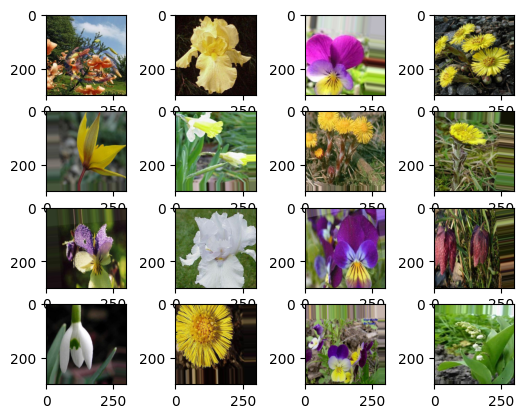

In [26]:
train_images = next(train_data)[0]
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(train_images[i])

## TransferLearning : weights="imagenet"

In [27]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , input_shape=(width,height,3))
#initial_model.summary()

## include_top = False :

 ## these 2 layers have been deleted :
 ### because of include_top=False
 avg_pool (GlobalAveragePoo(None,1536))                                                           
 predictions (Dense)(None, 1000)

In [28]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet" , include_top=False , input_shape=(width,height,3))
#initial_model.summary()

## حالا خودمون باید اون دوتا لایه رو بسازیم ::
اما لایه پولینگ رو میتونیم اینجوری بسازیم ::
اینجوری فقط لایه دنس را حذف کردیم

In [ ]:
initial_model = tf.keras.applications.InceptionResNetV2(weights="imagenet",
                                                        include_top=False,
                                                        pooling="avg",
                                                        input_shape=(width,height,3))
initial_model.summary()

# FREEZING SOME LAYERS :

نمیخوایم همه ی لایه ها ترین بشن

## اگر بخوایم چهار لایه آخر شبکه فریز نشوند  :
چهارتای آخر را درنظر نمیگیریم
یعنی میخوایم ۴ لایه آخر شبکه ترین بشوند ولی بقیه نه  

In [30]:
for layer in initial_model.layers[:-4]:
 layer.trainable=False

#initial_model.summary()

In [31]:
model = tf.keras.models.Sequential([
    initial_model,
    tf.keras.layers.Dropout(0.2), # 0.2 is probability that a neuron will be inactive and 80% active
    tf.keras.layers.Dense(17 , activation="softmax")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 1536)              54336736  
 ional)                                                          
                                                                 
 dropout_1 (Dropout)         (None, 1536)              0         
                                                                 
 dense_1 (Dense)             (None, 17)                26129     
                                                                 
Total params: 54362865 (207.38 MB)
Trainable params: 3222545 (12.29 MB)
Non-trainable params: 51140320 (195.08 MB)
_________________________________________________________________


In [32]:
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001) ,
              loss=tf.keras.losses.categorical_crossentropy ,
              metrics=["accuracy"] )

In [33]:
run = wandb.init(project="17flowers")

In [34]:
from wandb.sdk.wandb_run import wandb_metric
config = wandb.config
from wandb.keras import (
   WandbMetricsLogger,
   WandbModelCheckpoint,
)

wandb_callbacks = [
   WandbMetricsLogger(log_freq=5),
   WandbModelCheckpoint("models"),
]

In [35]:
history = model.fit(train_data , validation_data=validation_data , epochs=10 , callbacks=wandb_callbacks)


Epoch 1/10
29/29 [==============================] - ETA: 0s - loss: 1.1305 - accuracy: 0.6811 

wandb: Adding directory to artifact (./models)... Done. 1.8s


29/29 [==============================] - 803s 27s/step - loss: 1.1305 - accuracy: 0.6811 - val_loss: 0.4796 - val_accuracy: 0.8737
Epoch 2/10
29/29 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.8865

wandb: Adding directory to artifact (./models)... Done. 0.8s


29/29 [==============================] - 102s 4s/step - loss: 0.4185 - accuracy: 0.8865 - val_loss: 0.2742 - val_accuracy: 0.9263
Epoch 3/10
29/29 [==============================] - ETA: 0s - loss: 0.2751 - accuracy: 0.9438

wandb: Adding directory to artifact (./models)... Done. 1.5s


29/29 [==============================] - 101s 4s/step - loss: 0.2751 - accuracy: 0.9438 - val_loss: 0.2452 - val_accuracy: 0.9368
Epoch 4/10
29/29 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9632

wandb: Adding directory to artifact (./models)... Done. 2.7s


29/29 [==============================] - 100s 4s/step - loss: 0.2000 - accuracy: 0.9632 - val_loss: 0.2555 - val_accuracy: 0.9158
Epoch 5/10
29/29 [==============================] - ETA: 0s - loss: 0.1610 - accuracy: 0.9784

wandb: Adding directory to artifact (./models)... Done. 2.3s


29/29 [==============================] - 100s 4s/step - loss: 0.1610 - accuracy: 0.9784 - val_loss: 0.1833 - val_accuracy: 0.9368
Epoch 6/10
29/29 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9795

wandb: Adding directory to artifact (./models)... Done. 2.5s


29/29 [==============================] - 102s 4s/step - loss: 0.1292 - accuracy: 0.9795 - val_loss: 0.1805 - val_accuracy: 0.9474
Epoch 7/10
29/29 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9870

wandb: Adding directory to artifact (./models)... Done. 1.5s


29/29 [==============================] - 100s 4s/step - loss: 0.1108 - accuracy: 0.9870 - val_loss: 0.1859 - val_accuracy: 0.9368
Epoch 8/10
29/29 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9903

wandb: Adding directory to artifact (./models)... Done. 1.0s


29/29 [==============================] - 103s 4s/step - loss: 0.0970 - accuracy: 0.9903 - val_loss: 0.1663 - val_accuracy: 0.9474
Epoch 9/10
29/29 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9903

wandb: Adding directory to artifact (./models)... Done. 1.8s


29/29 [==============================] - 103s 4s/step - loss: 0.0808 - accuracy: 0.9903 - val_loss: 0.1398 - val_accuracy: 0.9789
Epoch 10/10
29/29 [==============================] - ETA: 0s - loss: 0.0754 - accuracy: 0.9946

wandb: Adding directory to artifact (./models)... Done. 0.9s


29/29 [==============================] - 102s 4s/step - loss: 0.0754 - accuracy: 0.9946 - val_loss: 0.1129 - val_accuracy: 0.9789


| Layers Freezed|without Dropout| with Droput = 0.2 |with Droput = 0.5 |
| ------------- | :-------------: | :-------------: |:-------------: |
| validation Accuracy  | -  | -  | -  |


|without Freezing layers|without Dropout| with Droput = 0.2 | with Droput = 0.5 |
| ------------- | :-------------: | :-------------: | :-------------: |
| validation Accuracy  | -  | -  | -  |


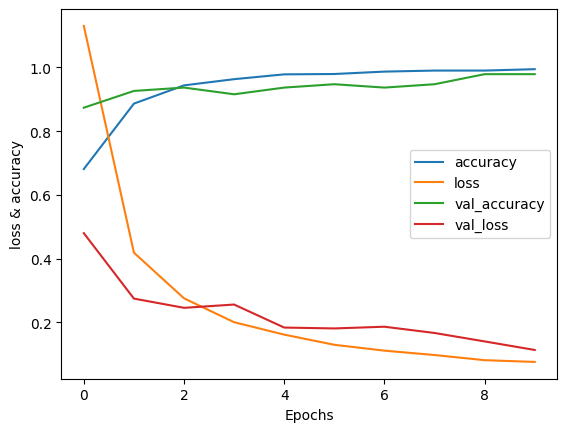

In [36]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"], label='Train')
plt.plot(history.history["val_accuracy"], label='Validation')
plt.plot(history.history["val_loss"])
plt.legend(["accuracy","loss" , "val_accuracy" , "val_loss"])
plt.xlabel("Epochs")
plt.ylabel("loss & accuracy")
plt.show()

In [37]:
images,labels = validation_data[1]
ypred_list = []
for image in images:
    image = np.expand_dims(image, axis=0)
    ypred=model.predict(image)
    ypred_list.append(np.argmax(ypred))
ytrue_list = []
for label in labels:
    ytrue_list.append(np.argmax(label))

1/1 [==============================] - 0s 55ms/step


In [38]:
np.array(ytrue_list)

array([ 4,  0,  2, 12, 13, 11, 11,  2, 12,  2,  2, 10, 16,  8,  7, 12, 15,
       13, 14,  5, 16,  3,  8,  8,  5,  4,  9, 14,  3,  6, 16,  5])

In [39]:
np.array(ypred_list)

array([ 4,  0,  2, 12, 13, 11, 11,  2, 12,  2,  2, 10, 16,  8,  7, 12, 15,
       13, 14,  5, 16,  3,  8,  8,  1,  4,  9, 14,  3,  6, 16,  5])

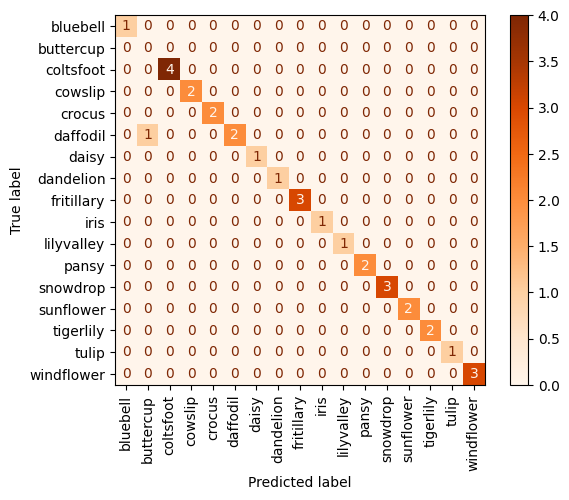

In [40]:
confm = metrics.confusion_matrix(y_true= ytrue_list , y_pred= ypred_list  )
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confm , display_labels=['bluebell', 'buttercup', 'coltsfoot', 'cowslip', 'crocus', 'daffodil', 'daisy', 'dandelion', 'fritillary', 'iris', 'lilyvalley', 'pansy', 'snowdrop', 'sunflower', 'tigerlily', 'tulip', 'windflower'])
cm_display.plot(cmap=plt.cm.Oranges , xticks_rotation="vertical")
plt.show()

# Inference

In [41]:
#model= tf.keras.models.load_model("/content/drive/MyDrive/5animals_weights.keras")

شبکه همیشه تصاویر را به صورت بچ میخواد از ما . یعنی ورودی شبکه همیشه ۴ بعدی است .
یکی از این ۴ تا بعد بچ سایز است
اما حالا که فقط میخوایم یک تصویر بدیم بازم باید تصویر رو ۴ بعدی بکنیم


1/1 [==============================] - 0s 71ms/step
4
{'bluebell': 0, 'buttercup': 1, 'coltsfoot': 2, 'cowslip': 3, 'crocus': 4, 'daffodil': 5, 'daisy': 6, 'dandelion': 7, 'fritillary': 8, 'iris': 9, 'lilyvalley': 10, 'pansy': 11, 'snowdrop': 12, 'sunflower': 13, 'tigerlily': 14, 'tulip': 15, 'windflower': 16}
predicted label :  crocus


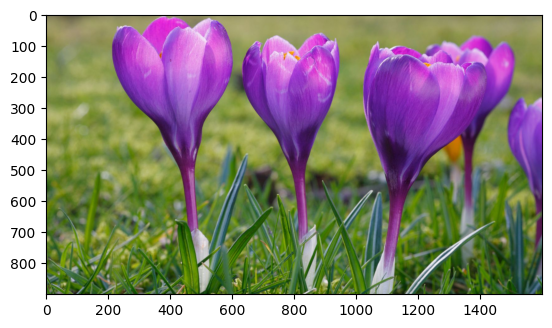

In [43]:
import cv2

new_image = cv2.imread("/content/crocus.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 52ms/step
4
{'bluebell': 0, 'buttercup': 1, 'coltsfoot': 2, 'cowslip': 3, 'crocus': 4, 'daffodil': 5, 'daisy': 6, 'dandelion': 7, 'fritillary': 8, 'iris': 9, 'lilyvalley': 10, 'pansy': 11, 'snowdrop': 12, 'sunflower': 13, 'tigerlily': 14, 'tulip': 15, 'windflower': 16}
predicted label :  crocus


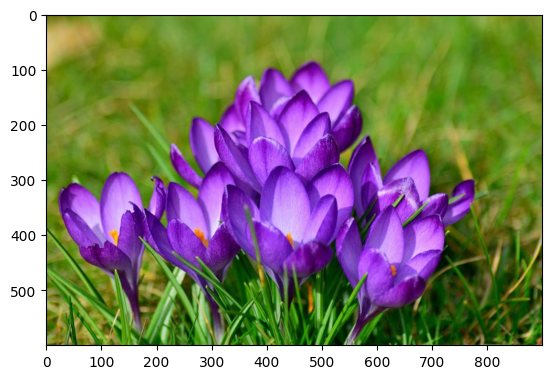

In [44]:
new_image = cv2.imread("/content/cu.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])

1/1 [==============================] - 0s 50ms/step
6
{'bluebell': 0, 'buttercup': 1, 'coltsfoot': 2, 'cowslip': 3, 'crocus': 4, 'daffodil': 5, 'daisy': 6, 'dandelion': 7, 'fritillary': 8, 'iris': 9, 'lilyvalley': 10, 'pansy': 11, 'snowdrop': 12, 'sunflower': 13, 'tigerlily': 14, 'tulip': 15, 'windflower': 16}
predicted label :  daisy


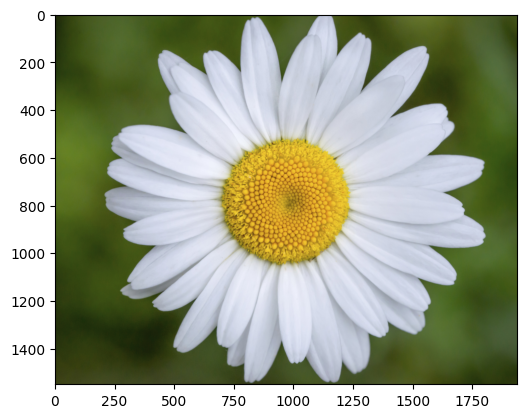

In [45]:
new_image = cv2.imread("/content/da.jpg")
new_image = cv2.cvtColor(new_image , cv2.COLOR_BGR2RGB)
plt.imshow(new_image)
new_image = cv2.resize(new_image , (299,299))
new_image = new_image / 255.0
new_image = np.reshape(new_image, [1, 299, 299, 3]) # new_iamge.reshape(1,299,299,3)

output = model.predict(new_image)

predicted_class = np.argmax(output)
print(predicted_class)
print(train_data.class_indices)
mylist = list(train_data.class_indices)
print("predicted label : " , mylist[np.argmax(output)])